# Import The Useable Libraries:

In [91]:
import numpy as np
import pandas as pd
import string
import random
from time import time
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad
from Crypto.Random import get_random_bytes
import base64
from Crypto.Util.Padding import unpad
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from decimal import Decimal, getcontext
import scienceplots

# **Define The Global Notebook Settings:** 

In [92]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 500)
plt.rcParams.update({'font.size': 14})
plt.style.use(['science', 'no-latex'])
plt.rcParams['font.family'] = 'Times New Roman'

# **Define The Global Variables:** 

In [93]:
def get_random_8chars(chars_length, n_sambles):
    random_chars = []
    for i in range(0, n_sambles, 1):
        letters = string.ascii_letters
        random_chars.append("".join(random.choice(letters)
                            for _ in range(chars_length)))
    return "".join(random_chars)

In [94]:
polynomials = [
    ([2, 2.5, 3], [2, -2, -3]),
    ([3, 3.5, 4, 4.5], [3, 3.7, -4, -4.5]),
    ([4, 4.5, 5, 5.5, 6], [-4, 4, 5, -5.5, -6]),
    ([5, 5.5, 6, 6.5, 7, 7.5], [5, 5.3, 6, -6.5, -7, -7.5]),
    ([6, 6.5, 7, 7.5, 8, 8.5, 9], [6, 6.7, 7, 7.5, -8, -8.5, -9]),
]

In [95]:
Degrees = []
for poly in polynomials:
    Degrees.append(len(poly[0]) - 1)

In [96]:
text_samples = []
text_sizes = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
# , 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000]
for size in text_sizes:
    text_samples.append(get_random_8chars(4, size))

In [97]:
secant_enc_time = []
secant_dec_time = []
secant_total_time = []

# ================

aes_enc_time = []
aes_dec_time = []
aes_total_time = []

# **Define The Global Classes:** 

In [98]:
Sbox = [
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
]
mix_column_matrix = [
    [0x02, 0x03, 0x01, 0x01],
    [0x01, 0x02, 0x03, 0x01],
    [0x01, 0x01, 0x02, 0x03],
    [0x03, 0x01, 0x01, 0x02]
]
Rcon = [
    0x01, 0x02, 0x04, 0x08, 0x10, 0x20, 0x40, 0x80, 0x1B, 0x36,
    0x6C, 0xD8, 0xAB, 0x4D, 0x9A, 0x2F, 0x5E, 0xBC, 0x63, 0xC6
]


def sub_bytes(state):
    return [Sbox[b] for b in state]


def shift_rows(state):
    return [
        state[0], state[5], state[10], state[15],
        state[4], state[9], state[14], state[3],
        state[8], state[13], state[2], state[7],
        state[12], state[1], state[6], state[11]
    ]


def mix_columns(state):
    result = [0] * 16
    for i in range(4):
        for j in range(4):
            result[i + j * 4] = (
                mix_column_matrix[0][i] * state[j * 4] +
                mix_column_matrix[1][i] * state[1 + j * 4] +
                mix_column_matrix[2][i] * state[2 + j * 4] +
                mix_column_matrix[3][i] * state[3 + j * 4]
            ) % 256
    return result


def add_round_key(state, round_key):
    return [(b1 ^ b2) for b1, b2 in zip(state, round_key)]


def key_expansion(key):
    key_schedule = [b for b in key]
    for i in range(16, 176, 4):
        temp = key_schedule[i-4:i]
        if i % 16 == 0:
            temp = sub_bytes(rot_word(temp)) + [Rcon[i//16 - 1], 0, 0, 0]
        key_schedule.extend(
            [a ^ b for a, b in zip(temp, key_schedule[i-16:i])])
    return key_schedule


def rot_word(word):
    return word[1:] + [word[0]]


def sub_word(word):
    return [Sbox[b] for b in word]


def aes_encrypt_block(block, key):
    round_keys = key_expansion(key)
    state = add_round_key(block, round_keys[:16])
    for round_num in range(1, 10):
        state = sub_bytes(state)
        state = shift_rows(state)
        state = mix_columns(state)
        round_key = round_keys[round_num * 16:(round_num + 1) * 16]
        state = add_round_key(state, round_key)
    state = sub_bytes(state)
    state = shift_rows(state)
    state = add_round_key(state, round_keys[160:])
    return state


def aes_encrypt(plaintext, key):
    if len(plaintext) % 16 != 0:
        raise ValueError(
            "Input plaintext must be a multiple of 16 bytes (128 bits)")
    key_exp = key_expansion(key)
    ciphertext = b""
    for i in range(0, len(plaintext), 16):
        block = bytes(aes_encrypt_block(plaintext[i:i+16], key_exp))
        ciphertext += block
    return ciphertext


def inv_sub_bytes(state):
    return [Sbox.index(b) for b in state]


def inv_shift_rows(state):
    return [
        state[0], state[13], state[10], state[7],
        state[4], state[1], state[14], state[11],
        state[8], state[5], state[2], state[15],
        state[12], state[9], state[6], state[3]
    ]


def inv_mix_columns(state):
    return mix_columns(state)


def aes_decrypt_block(block, key):
    round_keys = key_expansion(key)
    state = add_round_key(block, round_keys[10 * 16:])
    state = inv_shift_rows(state)
    state = inv_sub_bytes(state)
    for round_num in range(9, 0, -1):
        state = add_round_key(
            state, round_keys[round_num * 16:(round_num + 1) * 16])
        state = inv_mix_columns(state)
        state = inv_shift_rows(state)
        state = inv_sub_bytes(state)
    state = add_round_key(state, round_keys[:16])
    return state


def aes_decrypt(ciphertext, key):
    if len(ciphertext) % 16 != 0:
        raise ValueError(
            "Input ciphertext must be a multiple of 16 bytes (128 bits)")
    key_exp = key_expansion(key)
    decrypted_text = b""
    for i in range(0, len(ciphertext), 16):
        block = bytes(aes_decrypt_block(ciphertext[i:i+16], key_exp))
        decrypted_text += block
    return decrypted_text


def pkcs7_pad(data):
    pad_len = 16 - (len(data) % 16)
    return data + bytes([pad_len] * pad_len)


def pkcs7_unpad(data):
    pad_len = data[-1]
    return data[:-pad_len]

In [99]:
class ibga(object):
    def __init__(self, text, x, y):
        if type(text) != str or len(x) != len(y):
            raise ValueError("Invalid parameters passed")
        self.text = text
        self.len_text = len(text)
        self.x = [Decimal(i) for i in x]
        self.y = [Decimal(i) for i in y]
        self.coefs = None
        self.maximium_8utf_chars = Decimal(2122219134)
        self.minimum_8utf_chars = Decimal(538976288)
        self.len_x = len(x)

    def set_text(self, text):
        if type(text) != str:
            raise ValueError("Invalid text type passed")
        self.text = text

    def set_x_y(self, x, y):
        if len(x) != len(y):
            raise ValueError("Invalid x, y points size passed")
        self.x = [Decimal(i) for i in x]
        self.y = [Decimal(i) for i in y]
        self.len_x = len(x)
        self.coefs = None

    def encode_and_get_int_values(self, chunk):
        byte_representation = chunk.encode('utf-8')
        integer_representation = int.from_bytes(
            byte_representation, byteorder='big')
        return integer_representation

    def get_normalized_value(self, integer_value):
        decimal_value = Decimal(integer_value)
        normalized_value = (decimal_value - self.minimum_8utf_chars) / \
            (self.maximium_8utf_chars - self.minimum_8utf_chars)
        return normalized_value

    def get_inverse_normalized_value(self, normalized_value):
        integer_value = (normalized_value *
                         (self.maximium_8utf_chars - self.minimum_8utf_chars)) + self.minimum_8utf_chars
        return integer_value

    def get_normalized_values(self):
        normalized_values = []
        chunks = self.len_text // 4
        beg, end = 0, 0
        if chunks:
            end = 4
            for i in range(0, chunks, 1):
                chunk = self.text[beg: end]
                normalized_values.append(
                    self.get_normalized_value(self.encode_and_get_int_values(chunk)))
                beg = end
                end = beg + 4
        if (self.len_text / 4) % 1 != 0:
            chunk = self.text[end:]
            normalized_values.append(
                self.get_normalized_value(self.encode_and_get_int_values(chunk)))
        return normalized_values

    def get_interger_values(self, normalized_values):
        interger_values = []
        for normalized_value in normalized_values:
            interger_values.append(
                self.get_inverse_normalized_value(normalized_value))
        return interger_values

    def decode_and_get_strings(self, int_values):
        strings = []
        for int_value in int_values:
            int_value = np.ceil(int_value)
            byte_representation = int_value.to_bytes(
                (int_value.bit_length() + 7) // 8, byteorder='big')
            text = byte_representation.decode('utf-8')
            strings.append(text)
        return "".join(strings)

    def decode_and_get_string(self, int_value):
        int_value = np.ceil(int_value)
        byte_representation = int_value.to_bytes(
            (int_value.bit_length() + 7) // 8, byteorder='big')
        return (byte_representation.decode('utf-8'))

    def newton_forward_coefficients(self):
        n = len(self.x)
        coefficients = np.zeros(n, dtype=Decimal)
        for i in range(n):
            coefficients[i] = Decimal(self.y[i])
        for j in range(1, n):
            for i in range(n - 1, j - 1, -1):
                coefficients[i] = (coefficients[i] - coefficients[i - 1]) / \
                    (self.x[i] - self.x[i - j])
        self.coefs = coefficients

    def evaluate_interpolated_value(self, target, normalized_value=Decimal(0)):
        n = self.len_x
        result = Decimal(self.coefs[-1])
        for i in range(n - 2, -1, -1):
            result = Decimal(result) * \
                (Decimal(target) - Decimal(self.x[i])) + Decimal(self.coefs[i])
        return result - normalized_value

    def evaluate_derivative(self, x, normalized_value):
        n = len(self.coefs) - 1
        result = Decimal(n) * (self.coefs[-1] - normalized_value)
        for i in range(n - 1, 0, -1):
            result = result * \
                (Decimal(x) - Decimal(self.x[i])) + Decimal(i) * self.coefs[i]
        return result

    def secant(self, x0, x1, normalized_value, tol=Decimal(10 ** -10)):
        x_prev = Decimal(x0)
        x_curr = Decimal(x1)

        while abs(x_curr - x_prev) > tol:
            fx_prev = self.evaluate_interpolated_value(
                x_prev, normalized_value)
            fx_curr = self.evaluate_interpolated_value(
                x_curr, normalized_value)

            if fx_curr - fx_prev == 0:
                raise ValueError(
                    "Secant method cannot converge. Division by zero.")

            x_next = x_curr - fx_curr * (x_curr - x_prev) / (fx_curr - fx_prev)
            x_prev, x_curr = x_curr, x_next

        return x_curr

    def encryption(self, root_finding_algorithm='secant'):
        cipher_text = []
        self.newton_forward_coefficients()
        normalized_values = self.get_normalized_values()
        algorithms = {
            'secant': self.secant,
        }
        if root_finding_algorithm not in algorithms:
            raise ValueError(
                f"Invalid algorithm_name. Expected one of: {', '.join(algorithms.keys())}")

        selected_algorithm = algorithms[root_finding_algorithm]

        for normalized_value in normalized_values:
            cipher_text.append(selected_algorithm(
                self.x[0], self.x[-1], normalized_value))

        return cipher_text

    def decryption(self, cipher_text):
        text = []
        for root in cipher_text:
            norm = self.evaluate_interpolated_value(root)
            inverse = self.get_inverse_normalized_value(norm)
            text.append(self.decode_and_get_string(Decimal(round(inverse))))
        return "".join(text)

# Get The Encryption & Decrytion & Total Times For Bisection , Secant Hyprid With Differrent Polynomials Degree 2 : 6

> **Hint**: 
> 1)  According To The Useable Root Finding Algorithm Uncomment Its Callable Function Inside The Encryption Function. 
> 2) Root Finding Algorithms Analysis Woerking With Block Size 4bytes For (Bisection , False Position).

### **Get Encryption , Decryption , Total Times When Using Secant:** 

In [100]:
poly = polynomials[2]
for text in text_samples:
    obj = ibga(text, poly[0], poly[1])
    ibga_en_beg = time()
    ciper_text = obj.encryption('secant')
    ibga_en_end = time()
    enc_time = ibga_en_end - ibga_en_beg
    secant_enc_time.append(enc_time)

    ibga_dec_beg = time()
    text_decryption = obj.decryption(ciper_text)
    ibga_dec_end = time()
    dec_time = ibga_dec_end - ibga_dec_beg
    secant_dec_time.append(dec_time)

    secant_total_time.append(enc_time + dec_time)
    print(text_decryption == text)

True
True
True
True
True
True
True
True
True
True


## Using AES:

In [102]:
for text in text_samples:
    aes_enc_beg = time()
    key = b'sfisdfjslkdjfs'
    text_ = text.encode('utf-8')
    padded_text = pkcs7_pad(text_)
    ciphertext = aes_encrypt(padded_text, key)
    aes_enc_end = time()
    enc_time = aes_enc_end - aes_enc_beg
    aes_enc_time.append(enc_time)

    aes_dec_beg = time()
    decrypted_text = pkcs7_unpad(aes_decrypt(ciphertext, key))
    aes_dec_end = time()
    dec_time = aes_dec_end - aes_dec_beg
    aes_dec_time.append(dec_time)

    aes_total_time.append(enc_time + dec_time)

---

In [103]:
# Polynomial Deg & Text Array Size
print(polynomials)
polynomials_degrees = []
for poly in polynomials:
    polynomials_degrees.append(len(poly[0]) - 1)

print(polynomials_degrees)
print(text_sizes)

[([2, 2.5, 3], [2, -2, -3]), ([3, 3.5, 4, 4.5], [3, 3.7, -4, -4.5]), ([4, 4.5, 5, 5.5, 6], [-4, 4, 5, -5.5, -6]), ([5, 5.5, 6, 6.5, 7, 7.5], [5, 5.3, 6, -6.5, -7, -7.5]), ([6, 6.5, 7, 7.5, 8, 8.5, 9], [6, 6.7, 7, 7.5, -8, -8.5, -9])]
[2, 3, 4, 5, 6]
[500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]


In [104]:
# Time Results
print(secant_enc_time)
print(secant_dec_time)
print(secant_total_time)


print(aes_enc_time)
print(aes_dec_time)
print(aes_total_time)

[0.09472107887268066, 0.10642313957214355, 0.16100764274597168, 0.22023797035217285, 0.28237485885620117, 0.358659029006958, 0.36753225326538086, 0.38482165336608887, 0.5264468193054199, 0.6448855400085449]
[0.010543346405029297, 0.011060714721679688, 0.016348600387573242, 0.02984309196472168, 0.03248023986816406, 0.04114174842834473, 0.04302072525024414, 0.046417236328125, 0.08171749114990234, 0.0852358341217041]
[0.10526442527770996, 0.11748385429382324, 0.17735624313354492, 0.25008106231689453, 0.31485509872436523, 0.39980077743530273, 0.410552978515625, 0.43123888969421387, 0.6081643104553223, 0.730121374130249]
[0.05306124687194824, 0.09914159774780273, 0.08483719825744629, 0.11224246025085449, 0.14719009399414062, 0.11536216735839844, 0.11135601997375488, 0.12942075729370117, 0.24168634414672852, 0.23540687561035156]
[0.1294405460357666, 0.22131800651550293, 0.23820161819458008, 0.2921762466430664, 0.3536112308502197, 0.41967201232910156, 0.3445460796356201, 0.4668867588043213, 0

## Plotting Results:

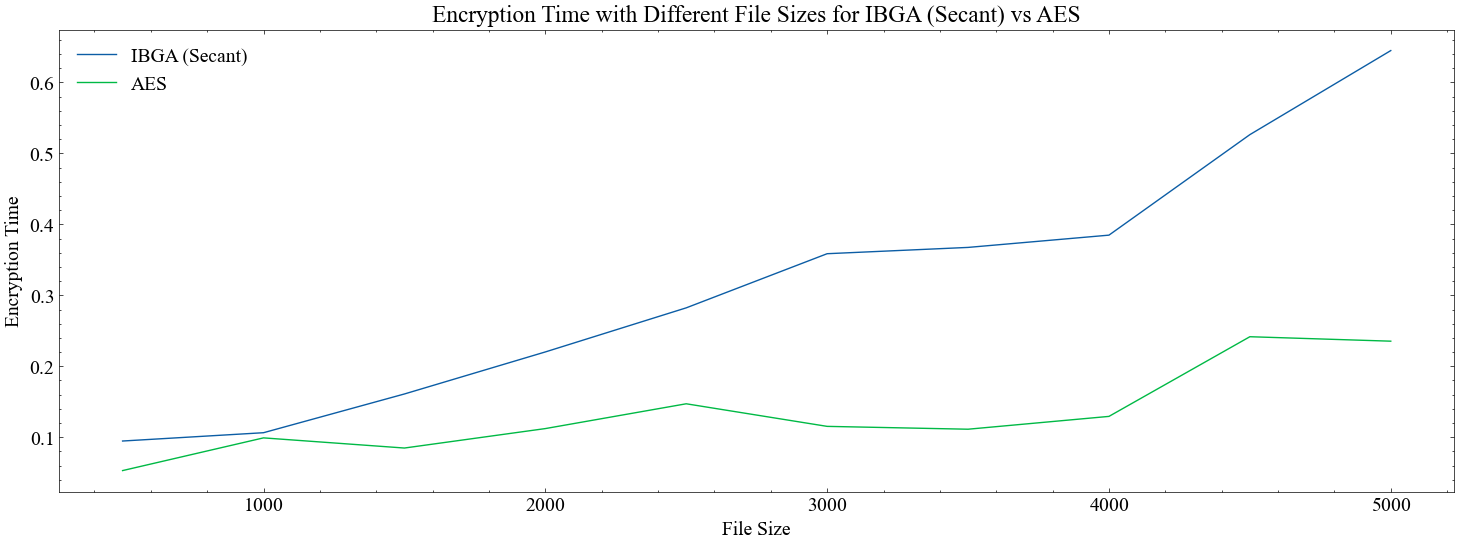

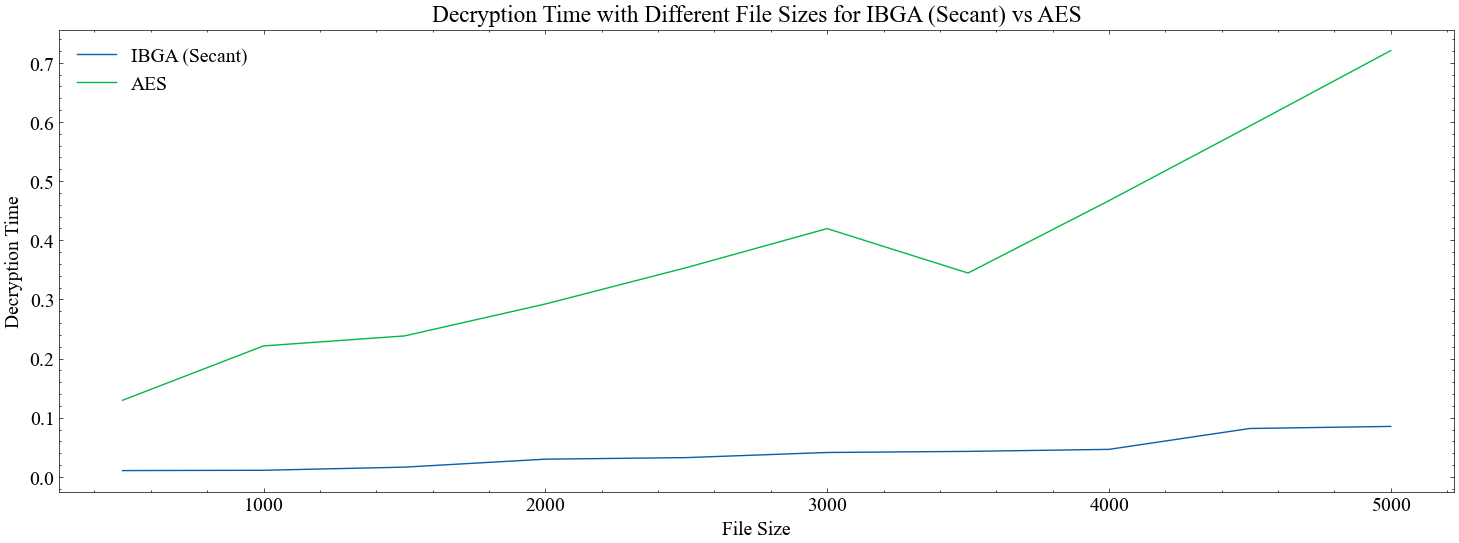

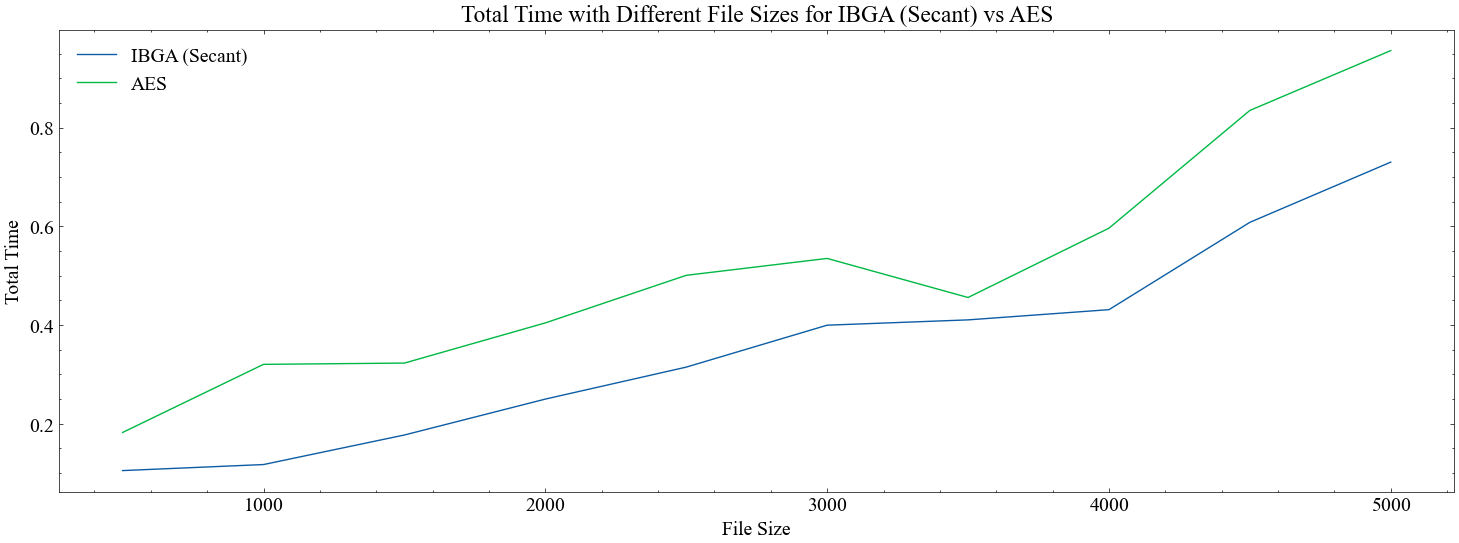

In [105]:
# Encryption Time Comparison
plt.figure(figsize=(18, 6))
plt.plot(text_sizes, secant_enc_time,  label='IBGA (Secant)')
plt.plot(text_sizes, aes_enc_time,  label='AES')
plt.xlabel('File Size')
plt.ylabel('Encryption Time')
plt.title('Encryption Time with Different File Sizes for IBGA (Secant) vs AES')
plt.legend()
plt.savefig(r"./encryption_time_comparison.svg", format="svg")
plt.show()

# Decryption Time Comparison
plt.figure(figsize=(18, 6))
plt.plot(text_sizes, secant_dec_time,  label='IBGA (Secant)')
plt.plot(text_sizes, aes_dec_time,  label='AES')
plt.xlabel('File Size')
plt.ylabel('Decryption Time')
plt.title('Decryption Time with Different File Sizes for IBGA (Secant) vs AES')
plt.legend()
plt.savefig(r"./decryption_time_comparison.svg", format="svg")
plt.show()

# Total Time Comparison
plt.figure(figsize=(18, 6))
plt.plot(text_sizes, secant_total_time,  label='IBGA (Secant)')
plt.plot(text_sizes, aes_total_time,  label='AES')
plt.xlabel('File Size')
plt.ylabel('Total Time')
plt.title('Total Time with Different File Sizes for IBGA (Secant) vs AES')
plt.legend()
plt.savefig(r"./total_time_comparison.svg", format="svg")
plt.show()